# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
import os.path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mean_absolute_error

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
# Смотрим размер выборки
labels.shape

(7591, 2)

In [ ]:
# Смотрим общую информацию о выборке
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# Проверяем на количество дубликатов
labels.duplicated().sum()

0

In [ ]:
# Проверяем на наличие пропусков
labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [ ]:
# Изучаем распределение значений в выборке
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
# Смотрим содержимое
labels.sample(10)

,file_name,real_age
7340,007362.jpg,25
7464,007486.jpg,2
2955,002955.jpg,32
6241,006245.jpg,49
1754,001754.jpg,25
3699,003699.jpg,27
2978,002978.jpg,16
639,000639.jpg,20
3933,003933.jpg,43
7503,007525.jpg,23


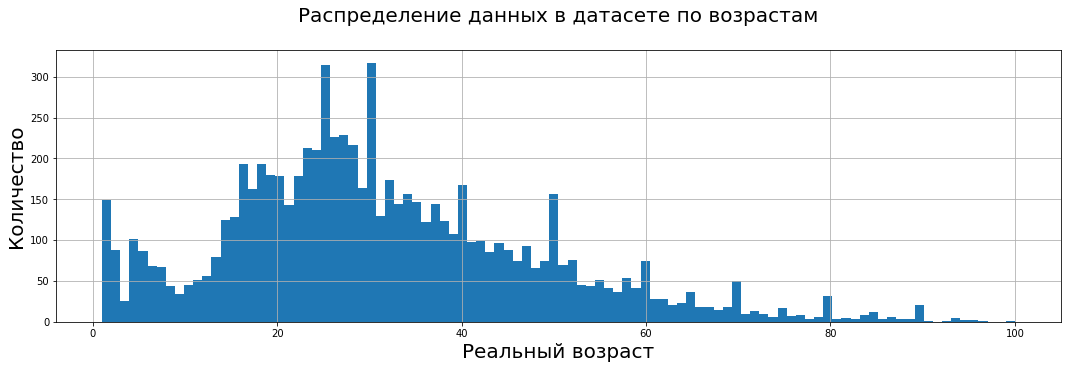

In [ ]:
# Строим график распределения возраста в выборке
plt.figure(figsize=(18,5))
plt.title('Распределение данных в датасете по возрастам\n', fontsize=20)
plt.xlabel('Реальный возраст', fontsize=20)
plt.ylabel('Количество', fontsize=20)
labels.real_age.hist(bins=100);

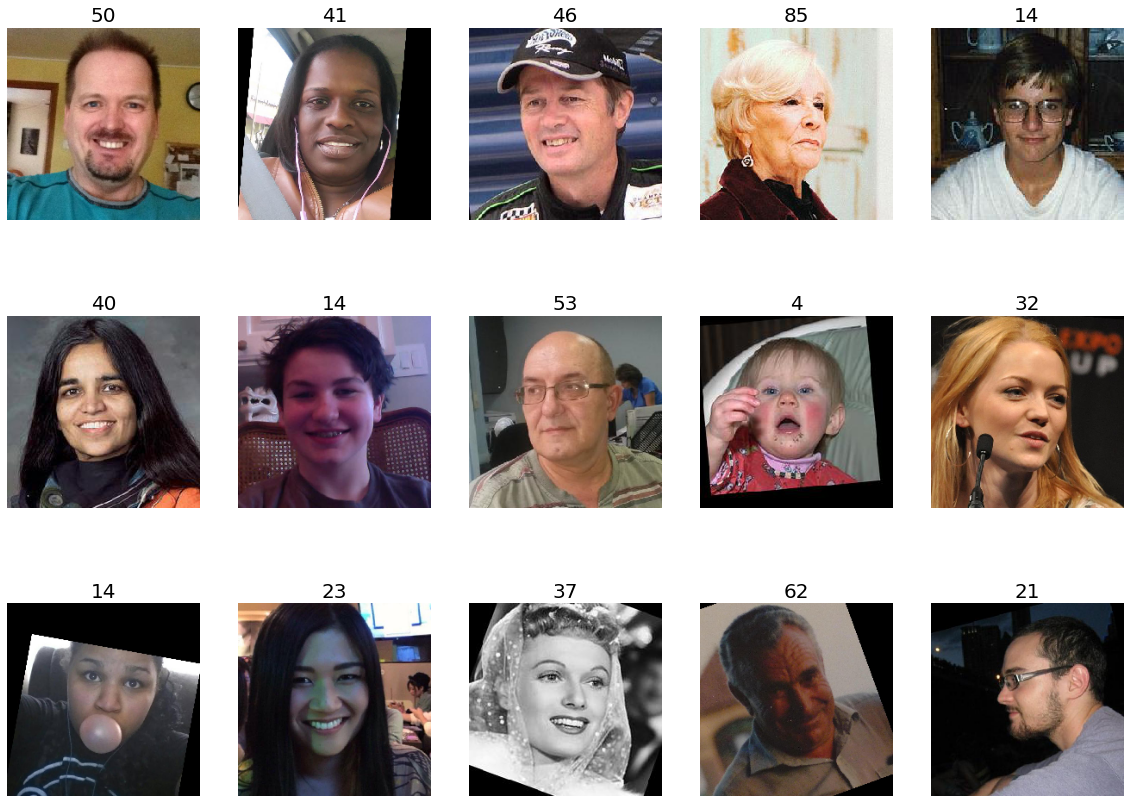

In [ ]:
# Указываем количество строк и столбцов
rows = 3
columns = 5

# Получаем первую партию изображений и возрастов
images_batch, ages_batch = next(train_gen_flow)

# Создаем подложку для графика с указанными размерами
fig = plt.figure(figsize=(20, 15))

# Основной цикл для вывода изображений и данных возраста
for i in range(columns * rows):
    img = images_batch[i]
    age = ages_batch[i]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(age, fontsize=20)

# Показываем график
plt.show()

**Промежуточный вывод:**

Загрузили и изучили набор данных:
- Состоит из 2-ух частей (папка с фотографиями, csv файл с возрастом человека и именем файла с фото)
- Всего в базе данных 7951 файл, пропусков нет, дубликатов не обнаружено
- Данные распределены следующим образом:
    - Минимальное значение - 1 год
    - Максимальное значение - 100 лет
    - Средний возраст - 31 год
    - Медианный возраст - 29 лет
    - Из изученной вручную выборке 15 фотографий данные возраста и визуальная оценка возраста по фото соответтвуют друг другу

Есть черно-белые фотографии, под углом, разных размеров, к тому же есть фото с лишними объектами перед лицом(жвачка, микрофон и пр.)
    
Фотографии выглядят хорошо, без явных искажений в области лица.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 116s - loss: 204.8660 - mae: 10.4056 - val_loss: 632.3849 - val_mae: 20.0877
Epoch 2/10
356/356 - 40s - loss: 87.3944 - mae: 7.0922 - val_loss: 123.1090 - val_mae: 8.2698
Epoch 3/10
356/356 - 40s - loss: 56.3617 - mae: 5.7558 - val_loss: 83.0355 - val_mae: 6.7989
Epoch 4/10
356/356 - 40s - loss: 41.4288 - mae: 4.9632 - val_loss: 98.0594 - val_mae: 7.4277
Epoch 5/10
356/356 - 40s - loss: 31.8802 - mae: 4.3635 - val_loss: 70.8377 - val_mae: 6.3042
Epoch 6/10
356/356 - 40s - loss: 26.1412 - mae: 3.9406 - val_loss: 74.3797 - val_mae: 6.3822
Epoch 7/10
356/356 - 40s - loss: 21.7432 - mae: 3.5440 - val_loss: 92.1918 - val_mae: 7.1217
Epoch 8/10
356/356 - 40s - loss: 19.7696 - mae: 3.3835 - val_loss: 67.2342 - val_mae: 6.1477
Epoch 9/10
356/356 - 40s - loss: 15.3840 - mae: 3.0008 - val_loss: 74.9610 - val_mae: 6.4470
Epoch 10/10
356/356 - 40s - loss: 14.0712 - mae: 2.8653 - val_loss: 66.8269 - val_mae: 6.0457

119/119 - 10s - loss: 66.8269 - mae: 6.0457
Test MAE: 6.0457


```

Для обучения применили модель сверточной нейронной сети на ResNet50

Достигнули результата МАЕ - 6.0457 на тестовой выборке, что соответствует требованиям задачи (ниже 7)

Времени на обучение ушло сравнительно мало, в виду небольшого размера датасета

## Анализ обученной модели

Имея задачу определять возраст человека по изображению с MAE не больше 7, использовали датасет с 7591 размеченной фотографией, где преобладали изображения с низким освещением и вращением по горизонтальной оси. Чтобы улучшить точность обучения, выделили определенный процент данных для тренировки модели и использовали специальные гиперпараметры для эффективной аугментации данных. Оставшаяся часть была выделена для тестирования.

Основываясь на ResNet50, предобученной на подобных задачах, обучили нейросеть на нашем датасете, не замораживая ее. Использовали оптимизацию Adam с шагом обучения 0,0001 и функцию потерь mean_squared_error. После тестирования на 10 эпохах наших данных достигли значения MAE равное 6.0457, что подходит для нашей задачи.

Исходя из результата тестирования, считаю, что модель готова к использованию и может быть рекомендована для достижения желаемой точности предсказания возраста на изображении.